## I Load the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

df1 = pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2009-2010')
df2 = pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2010-2011')

data = pd.concat([df1, df2])

## II Preprocessing

In [2]:
data['Customer ID'].fillna(-1,inplace=True)
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'],format='%m/%d/%Y %H:%M')
data['Invoice']=data['Invoice'].astype(str)

data['Sales']=data['Price']*data['Quantity']

data['InvoiceDay'] = data['InvoiceDate'].dt.date

daily_sales=data[['Sales','InvoiceDay']].groupby('InvoiceDay').sum()
daily_sales

,Sales
InvoiceDay,
2009-12-01,53173.03
2009-12-02,62763.59
2009-12-03,68093.05
2009-12-04,40346.40
2009-12-05,9803.05
...,...
2011-12-05,57751.32
2011-12-06,54228.37
2011-12-07,75076.22


## III Add exogenuous variables

### a) Month number

In [3]:
df = daily_sales.copy()
df['month'] = [df.index[i].month for i in range(len(df))]
df=pd.get_dummies(df['month'])

daily_sales = daily_sales.join(df)

### b) Day of the week

In [4]:
df['weekday'] = [df.index[i].strftime('%A') for i in range(len(df))]
df=pd.get_dummies(df['weekday'])

daily_sales = daily_sales.join(df)

In [5]:
daily_sales = daily_sales.reset_index()

daily_sales = daily_sales.rename(columns={
    'Sales':'y',
    'InvoiceDay':'ds'
})
daily_sales = daily_sales.rename(columns={
    i:str(i) for i in range(1,13)
})

### c) time from start day

In [8]:
daily_sales['time'] = (daily_sales['ds'] - min(daily_sales['ds'])).astype('timedelta64[D]').astype(int)

In [9]:
daily_sales

,ds,y,1,2,3,4,5,6,7,8,...,11,12,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,time
0,2009-12-01,53173.03,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,2009-12-02,62763.59,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,1
2,2009-12-03,68093.05,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,2
3,2009-12-04,40346.40,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,3
4,2009-12-05,9803.05,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599,2011-12-05,57751.32,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,734
600,2011-12-06,54228.37,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,735
601,2011-12-07,75076.22,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,736
602,2011-12-08,81417.78,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,737


## IV Modelling

### Define the metrics and the sets

In [10]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

def compute_metrics(real, predicted):
    
    rmse = mean_squared_error(real, predicted, squared=False)
    r2 = r2_score(real, predicted)
    mape = mean_absolute_percentage_error(real, predicted)
    
    return(rmse, r2,mape)

train_set = int(len(daily_sales)*0.7)
val_set = int(len(daily_sales)*0.1)
dev = daily_sales.iloc[:train_set+val_set] 
train = daily_sales.iloc[:train_set] 
val = daily_sales.iloc[train_set:train_set+val_set]
test = daily_sales.iloc[train_set+val_set:]

### Create different models

In [11]:
from sklearn.linear_model import ElasticNet
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures

class LinModel:
    
    def __init__(self, alpha=0, l1_ratio=0):
        self.model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
        
    def fit(self, train):
        X_train, y_train = train.drop(['y','ds'], axis=1), train['y']
        #X_train = PolynomialFeatures(degree=2, interaction_only=True).fit_transform(X_train)
        self.model = self.model.fit(X_train, y_train)
    
    def predict(self, test):
        X_test = test.drop(['y','ds'], axis=1)
        #X_test = PolynomialFeatures(degree=2, interaction_only=True).fit_transform(X_test)
        preds = self.model.predict(X_test)
        
        return preds

class XGBModel:
    
    def __init__(self, n_estimators=100, max_depth=5):
        self.model = XGBRegressor(n_estimators = n_estimators, max_depth = max_depth)
        
    def fit(self, train):
        X_train, y_train = train.drop(['y','ds'], axis=1), train['y']
        self.model = self.model.fit(X_train, y_train)
    
    def predict(self, test):
        X_test = test.drop(['y','ds'], axis=1)
        preds = self.model.predict(X_test)
        
        return preds
    
class RFModel:
    
    def __init__(self, n_estimators=100, max_depth=5):
        self.model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
        
    def fit(self, train):
        X_train, y_train = train.drop(['y','ds'], axis=1), train['y']
        self.model = self.model.fit(X_train, y_train)
    
    def predict(self, test):
        X_test = test.drop(['y','ds'], axis=1)
        preds = self.model.predict(X_test)
        
        return preds


class ProphetModel:
    
    def __init__(self, changepoint_prior_scale=None, n_changepoints=None):
        self.model = Prophet()
        
        if changepoint_prior_scale:
            self.model.changepoint_prior_scale = changepoint_prior_scale
        if n_changepoints:
            self.model.n_changepoints = n_changepoints
        
        
        for k in range(1,13):
            self.model.add_regressor(str(k))
        for day in ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']:
            self.model.add_regressor(day)    

        self.model.changepoint_prior_scale = i
        self.model.n_changepoints = j
        
    def fit(self, train):
        self.train = train
        self.model = self.model.fit(train)
    
    def predict(self, test):
        future = self.model.make_future_dataframe(periods=(max(test['ds'])-max(self.train['ds'])).days)
        
        for k in range(1,13):
            future[str(k)] = [1 if future['ds'][l].month==k else 0 for l in range(len(future))]
        for day in ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']:
            future[day] = [1 if future['ds'][l].strftime('%A')==day else 0 for l in range(len(future))]  
            
        forecast = self.model.predict(future)
        preds = forecast[forecast['ds'].isin(test['ds'])]['yhat']
        
        return preds

Importing plotly failed. Interactive plots will not work.


In [46]:
m=LinModel()
m.fit(train)
preds=m.predict(test)
compute_metrics(test['y'], preds)[2]

0.30643060536752154

### Hyperparameter Tuning

#### Linear Model

In [53]:
# hyperparameters
alpha = [i for i in np.arange(0,0.1,0.01)]
l1_ratio = [i for i in np.arange(0,1,0.1)]

mini = np.inf
for a in alpha:
    for l in l1_ratio:
        
        m = LinModel(a, l)
        m.fit(train)
        preds = m.predict(val)
        
        lin_metrics = compute_metrics(val['y'], preds)[2]
        
        if lin_metrics<mini:
            mini = lin_metrics
            best_params_lin = (a,l)
            
print(f'the best parameters are {best_params_lin}, for a MAPE of {mini} on validation set')

the best parameters are (0.0, 0.0), for a MAPE of 0.36414578876628484 on validation set


#### Prophet

In [48]:
# hyperparameters
changepoint_prior_scale = [i for i in np.arange(0.05,0.1,0.01)]
n_changepoints = [i for i in range(25,30,1)]

mini = np.inf
for i in changepoint_prior_scale:
    for j in n_changepoints:
        
        m = ProphetModel(i, j)
        m.fit(train)
        preds = m.predict(val)
        
        prophet_metrics = compute_metrics(val['y'], preds)[2]
        
        if prophet_metrics<mini:
            mini = prophet_metrics
            best_params_prophet = (i,j)
            
print(f'the best parameters are {best_params_prophet}, for a MAPE of {mini} on validation set')

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.36042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85       699.967    0.00295959       99.2173   3.174e-05       0.001      135  LS failed, Hessian reset 
      99       700.112   0.000141075       68.7891      0.6972      0.6972      153   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155        700.13   2.81141e-08       72.5979      0.0487           1      240   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.36042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       700.032    0.00294118       81.5129   2.904e-05       0.001      149  LS failed, Hessian reset 
      99       700.108   0.000132649       61.3086      0.2419      0.5489      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121        700.14   2.56114e-05       49.3707   4.776e-07       0.001      221  LS failed, Hessian reset 
     148       700.141   4.63994e-06       66.8484   7.559e-08       0.001      298  LS failed, Hessian reset 
     164       700.141   3.42115e-09       42.1249     0.06974      0.2513      328   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.36042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       700.068   0.000551139       84.7806           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        700.14   1.45893e-06       63.1164           1           1      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       700.141    4.8644e-06       67.1309   6.571e-08       0.001      311  LS failed, Hessian reset 
     226       700.141   1.48306e-08        74.609     0.05231           1      337   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.36042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      72       699.282    0.00119202       102.557   1.016e-05       0.001      120  LS failed, Hessian reset 
      86       699.593     0.0011841       102.049   1.133e-05       0.001      170  LS failed, Hessian reset 
      99       699.678   0.000140113       62.5418      0.6845      0.6845      188   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       699.932    0.00064071       89.3685   5.138e-06       0.001      269  LS failed, Hessian reset 
     199       700.124   2.25529e-06       84.9457      0.5378      0.5378      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     253       700.142   6.60727e-09       80.6028   0.0005915           1      409   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.36042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       699.539   5.40147e-05       113.603      0.5275      0.5275      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       700.149   3.72983e-05       64.3057   6.226e-07       0.001      248  LS failed, Hessian reset 
     175        700.15   2.44962e-07       43.8275   5.243e-09       0.001      306  LS failed, Hessian reset 
     185        700.15   5.21219e-09       37.1362     0.03433           1      326   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.36042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       700.053    0.00272902       70.3581   3.549e-05       0.001      136  LS failed, Hessian reset 
      99       700.186   9.67036e-05       39.8518           1           1      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       700.203   2.12555e-05       54.8032   4.329e-07       0.001      222  LS failed, Hessian reset 
     158       700.206   4.30118e-09       37.2126    0.005264           1      282   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.36042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       699.995     0.0014492       68.3631   1.894e-05       0.001      157  LS failed, Hessian reset 
      99       700.126     0.0011519       68.5663           1           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       700.193    1.0636e-05        36.853           1           1      317   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     262       700.199   8.10323e-06       54.8761   1.261e-07       0.001      445  LS failed, Hessian reset 
     279       700.199   1.72201e-08       45.5723      0.1424      0.4265      470   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.36042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       700.048    0.00215535       72.5108   2.745e-05       0.001      137  LS failed, Hessian reset 
      99       700.203   5.74341e-05       48.2587           1           1      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       700.218   0.000123555       75.7318    1.78e-06       0.001      246  LS failed, Hessian reset 
     149       700.221   2.02386e-09       46.7564   4.925e-05      0.4542      267   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.36042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       700.053    0.00228866       98.3356   3.005e-05       0.001      130  LS failed, Hessian reset 
      99       700.174   3.56185e-05       45.0745      0.1937      0.7283      155   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     196       700.203   1.10999e-06       40.3431   2.585e-08       0.001      339  LS failed, Hessian reset 
     199       700.203   1.03457e-07       42.9293      0.2006      0.8503      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       700.203    1.2463e-07       30.7887   2.238e-09       0.001      398  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.36042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       700.075    0.00342253       82.6716      0.6711           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       700.088    0.00149767       71.9821   1.812e-05       0.001      155  LS failed, Hessian reset 
     199       700.202   1.87169e-05       43.3675      0.3416     0.03416      273   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     217       700.202   1.62968e-06       52.8391    2.93e-08       0.001      347  LS failed, Hessian reset 
     228       700.202   7.82412e-11       42.5695   0.0006807       0.262      371   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.36042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       700.078   0.000674784       83.8177      0.6505      0.6505      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       700.248    0.00115499       67.3274    1.64e-05       0.001      181  LS failed, Hessian reset 
     159       700.412   9.77207e-07       37.1071   2.571e-08       0.001      295  LS failed, Hessian reset 
     168       700.412    5.2426e-08         35.06      0.1646           1      309   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.36042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       700.207    0.00187429        113.57   2.435e-05       0.001      154  LS failed, Hessian reset 
      99       700.417   0.000255457       38.6279           1           1      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166       700.435   6.69879e-06       47.5225   1.282e-07       0.001      297  LS failed, Hessian reset 
     199       700.437    2.9178e-05       35.3887        2.73       0.273      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       700.437   8.73645e-08       41.5825     0.08218     0.08218      363   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.36042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       700.261   0.000877791       63.5748   1.279e-05       0.001      147  LS failed, Hessian reset 
      99       700.412    0.00126534       43.7762      0.6007      0.6007      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       700.425   4.92802e-06       46.8432   1.392e-07       0.001      221  LS failed, Hessian reset 
     199       700.455   0.000136061        38.974           1           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243        700.47   5.05152e-05       53.3735   9.976e-07       0.001      451  LS failed, Hessian reset 
     274       700.471   3.37083e-07       36.4226   6.257e-09       0.001      540  LS failed, Hessian reset 
     279       700.471    7.2013e-08         30.45           1   

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.36042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      77       700.159    0.00391211       152.804   5.822e-05       0.001      141  LS failed, Hessian reset 
      99       700.437   0.000121891       35.8101           1           1      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       700.447   3.09828e-05       42.3798   8.433e-07       0.001      286  LS failed, Hessian reset 
     182       700.448   8.78322e-08       36.0358   2.488e-09       0.001      371  LS failed, Hessian reset 
     183       700.448   6.90561e-08       31.8199           1           1      372   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.36042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90       700.274    0.00144964       90.6396   1.684e-05       0.001      148  LS failed, Hessian reset 
      99       700.388   0.000175257       49.8867      0.3663           1      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     172        700.43   1.69604e-05       59.3194   2.378e-07       0.001      299  LS failed, Hessian reset 
     199        700.43   2.08689e-07       38.7405           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211        700.43   6.72949e-08       55.3307      0.2132      0.7008      355   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.36042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       700.622    0.00117339       58.4616   2.348e-05       0.001      163  LS failed, Hessian reset 
      99       700.649   0.000828399       52.6574           1           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       700.739   7.03919e-05       35.3696           1           1      295   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     286       700.774   1.56621e-06       31.7607   5.431e-08       0.001      452  LS failed, Hessian reset 
     294       700.774   1.72838e-06       28.7447    4.71e-08       0.001      508  LS failed, Hessian reset 
     299       700.774   1.68508e-06       36.6895           1           1      515   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.36042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       700.735   2.47863e-05       21.4515           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       700.755   7.98726e-06       42.8571           1           1      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     229       700.783    5.9239e-05       48.3479   1.849e-06       0.001      370  LS failed, Hessian reset 
     275       700.785   9.97397e-07       27.4526   3.334e-08       0.001      478  LS failed, Hessian reset 
     287       700.785    3.9789e-08       37.2598      0.2382           1      494   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.36042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       700.312   0.000389118       31.9111      0.5939      0.5939      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       700.511    0.00119931       60.9485       2e-05       0.001      207  LS failed, Hessian reset 
     167       700.725   0.000244985       53.1123   4.032e-06       0.001      290  LS failed, Hessian reset 
     199       700.733   5.98156e-06       43.9365           1           1      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       700.733   1.73478e-06       40.6654     3.8e-08       0.001      403  LS failed, Hessian reset 
     230       700.733   1.92906e-07       29.9844      0.9404      0.9404      414   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.36042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       700.307    0.00319091       60.9724           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       700.494    0.00149223       58.2085   2.545e-05       0.001      184  LS failed, Hessian reset 
     157        700.72   0.000508128       48.9835   8.857e-06       0.001      280  LS failed, Hessian reset 
     199       700.728   1.31721e-06       39.5593           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207       700.729   1.40189e-05       39.3154   2.922e-07       0.001      389  LS failed, Hessian reset 
     262        700.73   2.42277e-07       29.4173     0.03843      0.5948      464   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.36042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      74       700.197   0.000505445       35.4102   1.312e-05       0.001      132  LS failed, Hessian reset 
      99       700.363   0.000491893       54.7497           1           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       700.576     0.0018032       80.2796   2.574e-05       0.001      231  LS failed, Hessian reset 
     159       700.725   2.87136e-05       43.6629   6.634e-07       0.001      314  LS failed, Hessian reset 
     199       700.726   1.06887e-05       37.1283           1           1      380   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       700.743   1.36736e-05       42.2703      0.6738      0.6738      505   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.36042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       700.825   0.000410474        46.692       0.852       0.852      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       701.048   2.68836e-06       27.1093       2.084      0.4834      264   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222       701.048   5.41038e-07       21.7165   1.562e-08       0.001      333  LS failed, Hessian reset 
     226       701.048    9.7699e-08       25.0217           1           1      340   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.36042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        701.03   0.000149601       41.9763      0.6798      0.6798      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       701.071    0.00084533       34.8965           1           1      272   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     289       701.075   4.59121e-06       29.0149   9.994e-08       0.001      436  LS failed, Hessian reset 
     299       701.075   1.04798e-07       30.2644           1           1      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     317       701.075   1.07856e-07       22.9148           1           1      477   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.36042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       700.643    0.00157798       44.1429           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       701.046    4.7439e-05       43.3756      0.3971           1      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     235       701.051   8.14224e-06        26.556   2.239e-07       0.001      349  LS failed, Hessian reset 
     299       701.053   4.03407e-07        39.547       2.328     0.02328      437   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     324       701.053   1.08112e-06       52.8833   2.348e-08       0.001      505  LS failed, Hessian reset 
     335       701.053    4.2047e-08       33.2965      0.1682      0.6253      520   
Optimization terminat

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.36042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       700.878     0.0055272        116.55    0.000101       0.001      141  LS failed, Hessian reset 
      99       701.003    0.00298142       69.8241           1           1      146   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     183        701.06   1.76447e-05       37.1071   4.518e-07       0.001      305  LS failed, Hessian reset 
     199       701.061   1.57811e-07       33.2357      0.8512      0.8512      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       701.061   6.24508e-08       28.5625      0.2433           1      352   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.36042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       700.532   0.000116349       47.0634      0.5953      0.5953      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       700.804    0.00176641        110.73    2.23e-05       0.001      171  LS failed, Hessian reset 
     199       701.056   7.89369e-06       47.8163      0.7596      0.7596      277   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       701.056   6.63304e-06       41.9064   1.339e-07       0.001      318  LS failed, Hessian reset 
     225       701.056   9.77328e-09       38.4334     0.09208     0.09208      350   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
the best parameters are (0.08000000000000002, 26), for a MAPE of 0.3104120894312113 on validati

#### XGBoost

In [49]:
# hyperparameters
n_estimators = [i for i in range(5, 100, 10)]
max_depth = [i for i in range(2, 50, 3)]

mini = np.inf
for n in n_estimators:
    for m in max_depth:
        
        model = XGBModel(n, m)
        model.fit(train)
        preds = model.predict(val)
        
        xgb_metrics = compute_metrics(val['y'], preds)[2]
        
        if xgb_metrics<mini:
            mini = xgb_metrics
            best_params_xgb = (n, m)
            
print(f'the best parameters are {best_params_xgb}, for a MAPE of {mini} on validation set')

the best parameters are (5, 5), for a MAPE of 0.3453805667957237 on validation set


#### Random Forest

In [50]:
# hyperparameters
n_estimators = [i for i in range(5, 100, 10)]
max_depth = [i for i in range(2, 50, 3)]

mini = np.inf
for n in n_estimators:
    for m in max_depth:
        
        model = RFModel(n, m)
        model.fit(train)
        preds = model.predict(val)
        
        rf_metrics = compute_metrics(val['y'], preds)[2]
        
        if rf_metrics<mini:
            mini = rf_metrics
            best_params_rf = (n, m)
            
print(f'the best parameters are {best_params_rf}, for a MAPE of {mini} on validation set')

the best parameters are (5, 5), for a MAPE of 0.3635079749044995 on validation set


#### Ridge regression

In [51]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import RepeatedKFold, GridSearchCV
class ridge:
    
    def __init__(self, alpha = 0):
        self.model = Ridge(alpha = alpha)
        
    def fit(self, train):
        X_train, y_train = train.drop(['y','ds'], axis=1), train['y']
        self.model = self.model.fit(X_train, y_train)
    
    def predict(self, test):
        X_test = test.drop(['y','ds'], axis=1)
        preds = self.model.predict(X_test)
        
        return preds

In [54]:
# hyperparameters
alpha = [i for i in np.arange(0,0.1,0.01)]

mini = np.inf
for a in alpha:
        
    m = ridge(a)
    m.fit(train)
    preds = m.predict(val)
        
    lin_metrics = compute_metrics(val['y'], preds)[2]
        
    if lin_metrics<mini:
        mini = lin_metrics
        best_params_ridge = a

print(f'the best parameters are {best_params_ridge}, for a MAPE of {mini} on validation set')

the best parameters are 0.01, for a MAPE of 0.36425537885813725 on validation set


### Train best models

In [55]:
lin = LinModel(best_params_lin[0], best_params_lin[1])
lin.fit(train)
lin_preds = lin.predict(test)
lin_metrics = compute_metrics(test['y'], lin_preds)
print(f'For Linear Model, RMSE={lin_metrics[0]} and MAPE={lin_metrics[2]} on test set')


prophet = ProphetModel(best_params_prophet[0], best_params_prophet[1])
prophet.fit(dev)
prophet_preds = prophet.predict(test)
prophet_metrics = compute_metrics(test['y'], prophet_preds)
print(f'For Prophet, RMSE={prophet_metrics[0]} and MAPE={prophet_metrics[2]} on test set')

xgb = XGBModel(best_params_xgb[0], best_params_xgb[1])
xgb.fit(dev)
xgb_preds = xgb.predict(test)
xgb_metrics = compute_metrics(test['y'], xgb_preds)
print(f'For XGBoost, RMSE={xgb_metrics[0]} and MAPE={xgb_metrics[2]} on test set')

rf = RFModel(best_params_rf[0], best_params_rf[1])
rf.fit(dev)
rf_preds = rf.predict(test)
rf_metrics = compute_metrics(test['y'], rf_preds)
print(f'For Random Forest, RMSE={xgb_metrics[0]} and MAPE={xgb_metrics[2]} on test set')

ridge = ridge(best_params_ridge)
ridge.fit(dev)
ridge_preds = rf.predict(test)
ridge_metrics = compute_metrics(test['y'], rf_preds)
print(f'For Random Forest, RMSE={ridge_metrics[0]} and MAPE={ridge_metrics[2]} on test set')

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


For Linear Model, RMSE=14694.263007248068 and MAPE=0.30643060536752154 on test set
Initial log joint probability = -15.3155
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        814.84    0.00105122       48.3363      0.4964      0.4964      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       814.851    0.00027304       46.4986   4.992e-06       0.001      166  LS failed, Hessian reset 
     199       814.859    1.7922e-06       54.4627      0.6119      0.6119      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       814.859   7.20411e-06       58.7361   1.706e-07       0.001      338  LS failed, Hessian reset 
     232        814.86   2.79462e-08       44.6126      0.1671      0.6144      374   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
For Prophet

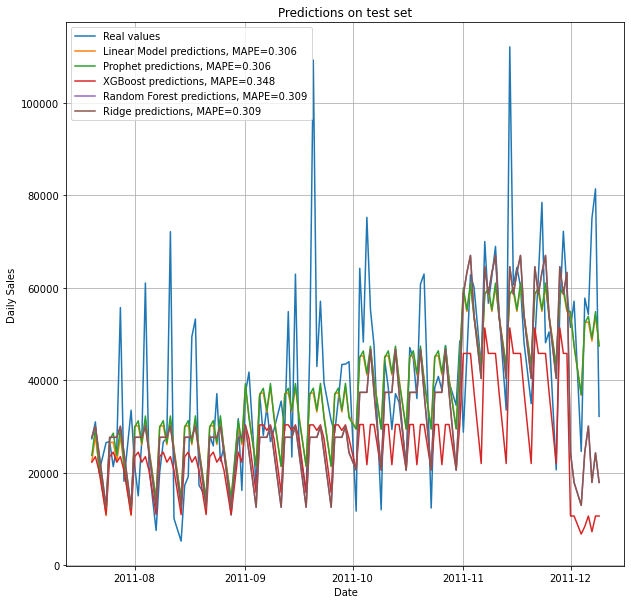

In [78]:
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(test['ds'], test['y'], label='Real values')
plt.plot(test['ds'], lin_preds, label=f'Linear Model predictions, MAPE={lin_metrics[2]:.3f}')
plt.plot(test['ds'], prophet_preds, label=f'Prophet predictions, MAPE={prophet_metrics[2]:.3f}')
plt.plot(test['ds'], xgb_preds, label=f'XGBoost predictions, MAPE={xgb_metrics[2]:.3f}')
plt.plot(test['ds'], rf_preds, label=f'Random Forest predictions, MAPE={rf_metrics[2]:.3f}')
plt.plot(test['ds'], ridge_preds, label=f'Ridge predictions, MAPE={ridge_metrics[2]:.3f}')

plt.title('Predictions on test set')
plt.ylabel('Daily Sales')
plt.xlabel('Date')
plt.grid()
plt.legend()

## V Observe MAPE over time

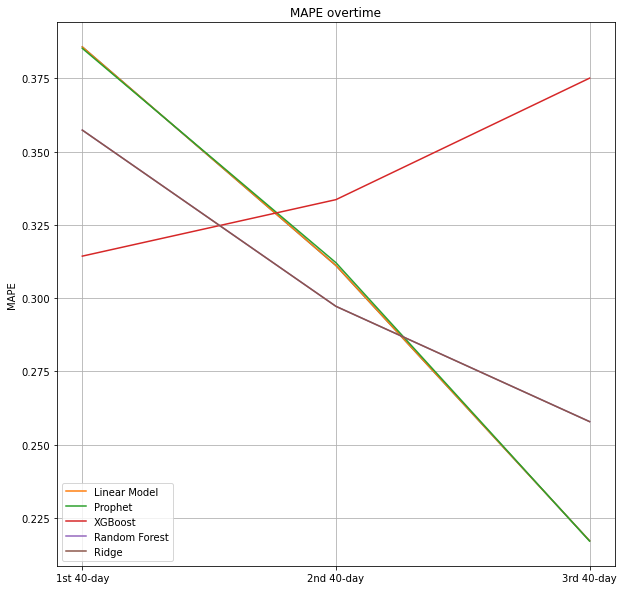

In [82]:
# MAPE over time
n = 3
preds = xgb_preds # change this line to switch model
time_range = len(test['y'])//n
mape_overtime_lin = []
mape_overtime_prophet = []
mape_overtime_xgb = []
mape_overtime_rf = []
mape_overtime_ridge = []

for i in range(n):
    mape_overtime_lin.append(compute_metrics(test['y'][time_range*i:time_range*(i+1)], lin_preds[time_range*i:time_range*(i+1)])[2])
    mape_overtime_prophet.append(compute_metrics(test['y'][time_range*i:time_range*(i+1)], prophet_preds[time_range*i:time_range*(i+1)])[2])
    mape_overtime_xgb.append(compute_metrics(test['y'][time_range*i:time_range*(i+1)], xgb_preds[time_range*i:time_range*(i+1)])[2])
    mape_overtime_rf.append(compute_metrics(test['y'][time_range*i:time_range*(i+1)], rf_preds[time_range*i:time_range*(i+1)])[2])
    mape_overtime_ridge.append(compute_metrics(test['y'][time_range*i:time_range*(i+1)], ridge_preds[time_range*i:time_range*(i+1)])[2])
#print([round(x, 3) for x in mape_overtime])
    
plt.plot(np.arange(0,n,1), mape_overtime_lin)
plt.plot(np.arange(0,n,1), mape_overtime_lin, label='Linear Model')
plt.plot(np.arange(0,n,1), mape_overtime_prophet, label='Prophet')
plt.plot(np.arange(0,n,1), mape_overtime_xgb, label='XGBoost')
plt.plot(np.arange(0,n,1), mape_overtime_rf, label='Random Forest')
plt.plot(np.arange(0,n,1), mape_overtime_ridge, label='Ridge')
plt.title('MAPE overtime')
plt.ylabel('MAPE')
plt.xlabel('')
plt.xticks(np.arange(0,n,1), ['1st 40-day', '2nd 40-day', '3rd 40-day'])

plt.grid()
plt.legend()

In [65]:
print([round(x, 3) for x in mape_overtime])

[0.385, 0.312, 0.217]